# Variational Quantum Adiabatic Algorithm (VQAA)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register

from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform
import networkx as nx
from networkx.algorithms import approximation as approx
from scipy.optimize import minimize

# 1.  Five atoms graph

Maximum independent set of G: {1, 3, 4}


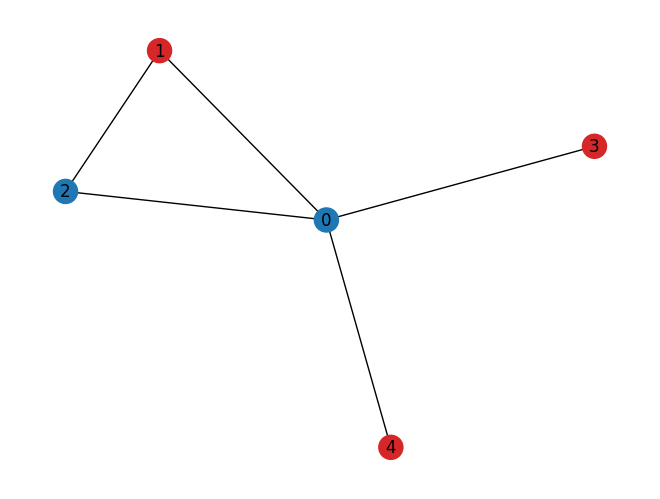

In [2]:
G = nx.Graph(
    [
        (0, 1),
        (0, 2),
        (0, 3),
        (0, 4),
        (1, 2),
    ]
) 

I = approx.maximum_independent_set(G)
print(f"Maximum independent set of G: {I}")

pos = nx.spring_layout(G) #, seed=39299899
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color=["tab:red" if n in I else "tab:blue" for n in G],
)

In [3]:
nx.adjacency_matrix(G).todense()

array([[0, 1, 1, 1, 1],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

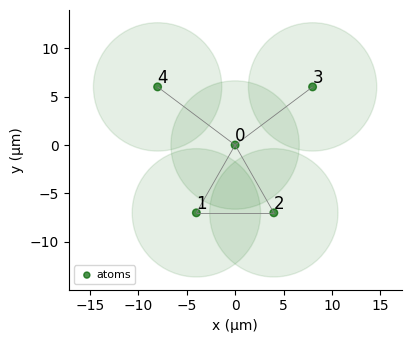

In [4]:
qubits = {'0': (0,0), '1': (-4,-7), '2': (4, -7), '3': (8,6), '4': (-8, 6)}
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

In [5]:
## Calculating the cost of a single configuaration of the graph
def get_cost(bitstring, G, penalty =10):
    z = np.array(list(bitstring), dtype = int)
    A = np.array(nx.adjacency_matrix(G).todense())
    
    # Add penalty and bias:
    cost = penalty*(z.T @ np.triu(A) @ z) - np.sum(z)
    return cost

## Weighted average over all the configurations of the graph
def get_avg_cost(counts, G):
    avg_cost = sum(counts[key] * get_cost(key, G) for key in counts)
    avg_cost = avg_cost / sum(counts.values()) # Divide by total samples
    
    return avg_cost

## Cost function to minimize
def func(param, *args):
    G = args[0]
    C = quantum_loop(param)
    cost = get_avg_cost(C, G)
    
    return cost

In [6]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key = lambda item: item[1], reverse = True))
    #indexes = ['01011', '00111']
    #color_dict = {key: 'r' if key in indexes else 'g' for key in C}
    plt.figure(figsize= (12,6))
    plt.xlabel('bitstings')
    plt.ylabel('counts')
    plt.bar(C.keys(), C.values(), width = 0.5) #, color = color_dict.values()
    plt.xticks(rotation = 'vertical')
    plt.show()

In [7]:
def adiabatic_sequence(device, register, time,  Omega = 3.271543 , detuning = 5):
    """Creates the adiabatic sequence

    Args:
        device: physical device simulation 
        Omega
        register: arrangement of atoms in a quantum processor
        time: time of the adiabatic process

    Returns:
        sequence 
    """
    
    delta_0 = -detuning
    delta_f = -delta_0
    
    adiabatic_pulse = Pulse(
    InterpolatedWaveform(time, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(time, [delta_0, 0, delta_f]),
    0,
    )
    
    sequence = Sequence(register, device)
    sequence.declare_channel('ising', 'rydberg_global')
    sequence.add(adiabatic_pulse, 'ising')

    return sequence

In [8]:
# Building the quantum loop

def quantum_loop(parameters):
    
    params = np.array(parameters)

    parameter_time, parameter_omega, parameter_detuning = np.reshape(params.astype(int), 3)
    seq = adiabatic_sequence(Chadoq2,reg, parameter_time, Omega = parameter_omega, detuning = parameter_detuning)
   
    simul = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
    res = simul.run()
    counts = res.sample_final_state(N_samples = 1000) #Sample from the state vector
    #print(counts)
    
    return counts


## 1.2 Random parameter test

In [9]:
random_omega = np.random.uniform(1,10)
random_detuning = np.random.uniform(1,10)
random_time = 1000*np.random.randint(5, 15)
parameters =[random_time,random_omega, random_detuning]

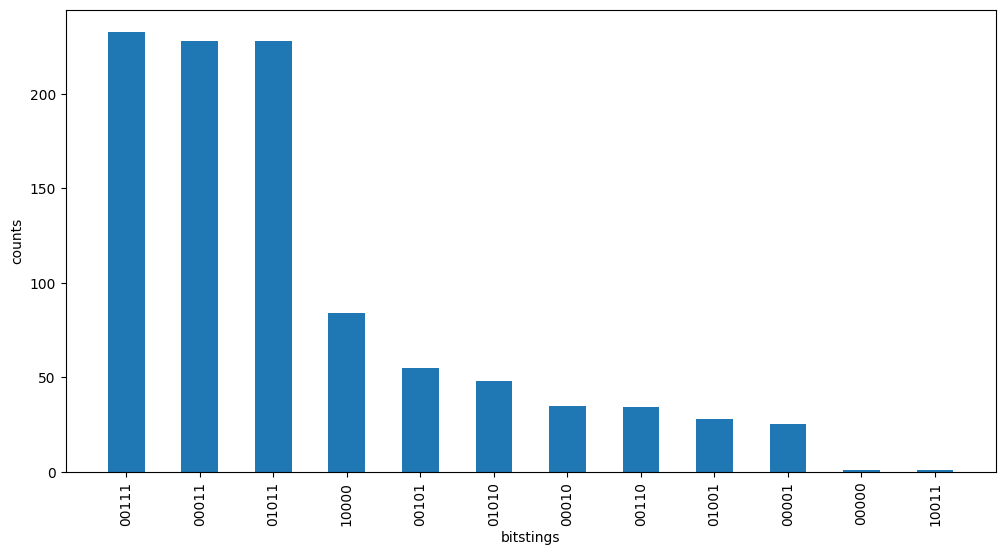

In [11]:
random_counts = quantum_loop(parameters)
plot_distribution(random_counts)

## 1.3 Variational process 

In [12]:
scores = []
params = []

random_omega = np.random.uniform(1,10)
random_detuning = np.random.uniform(1,10)
random_time = 1000*np.random.randint(5, 15)
    
res = minimize(
    func,
    args = G,
    x0 = np.r_[random_time, random_omega,random_detuning],
    method = 'Nelder-Mead',
    tol = 1e-5,
    options = {'maxiter':10},
    )

print(res.fun)
scores.append(res.fun)
params.append(res.x)

/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 11550 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 11552 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 11366 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 11368 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 11611 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 11612 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 11361 ns is not a multiple of the channel's clock period (4 ns

-2.816


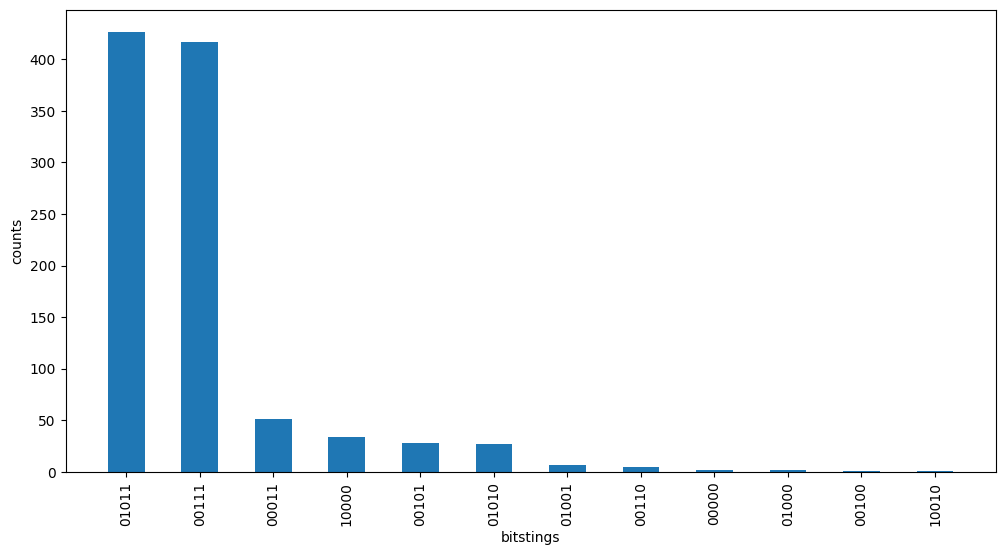

In [13]:
random_counts = quantum_loop(res.x)
plot_distribution(random_counts)

/tmp/ipykernel_24656/3115109674.py:18: UserWarning: A waveform duration of 11218.981481481478 ns is below the supported precision of 1 ns. It was rounded down to 11218 ns.
  InterpolatedWaveform(time, [1e-9, Omega, 1e-9]),
/tmp/ipykernel_24656/3115109674.py:19: UserWarning: A waveform duration of 11218.981481481478 ns is below the supported precision of 1 ns. It was rounded down to 11218 ns.
  InterpolatedWaveform(time, [delta_0, 0, delta_f]),


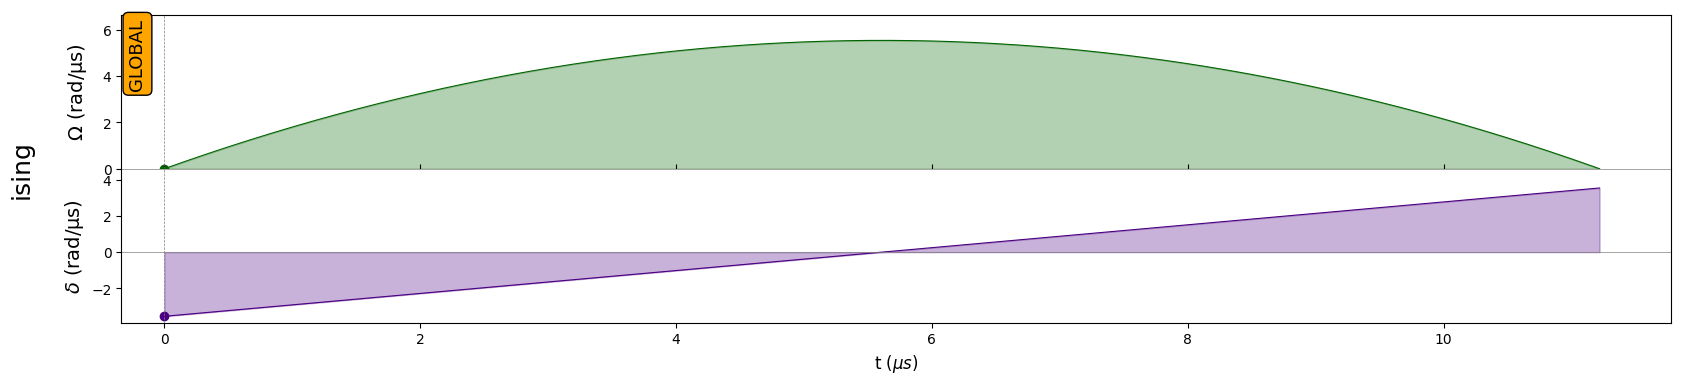

In [14]:
seq = adiabatic_sequence(Chadoq2,reg, res.x[0], res.x[1], res.x[2])

seq.draw()

# 2. 8 atoms graph 

Maximum independent set of G: {3, 4, 5, 6}


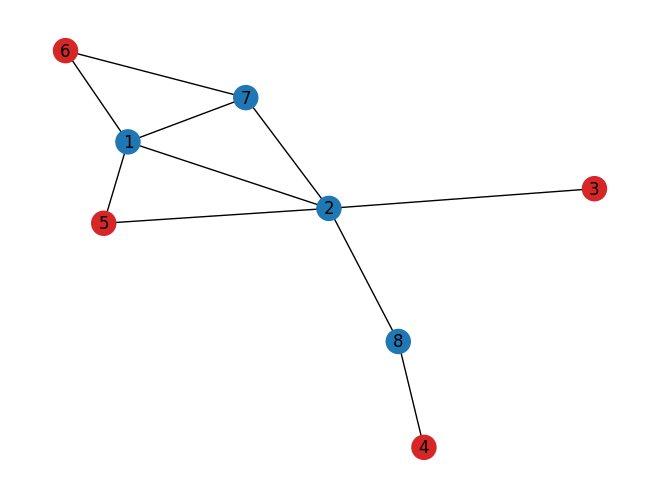

In [15]:
G_8 = nx.Graph(
    [
        (1, 2),
        (7, 2),
        (3, 2),
        (7, 6),
        (5, 2),
        (1, 5),
        (2, 8),
        (1, 7),
        (6, 1),
        (8, 4),
    ]
)

I = approx.maximum_independent_set(G_8)
print(f"Maximum independent set of G: {I}")

pos = nx.spring_layout(G_8, seed=39299899)
nx.draw(
    G_8,
    pos=pos,
    with_labels=True,
    node_color=["tab:red" if n in I else "tab:blue" for n in G_8],
)

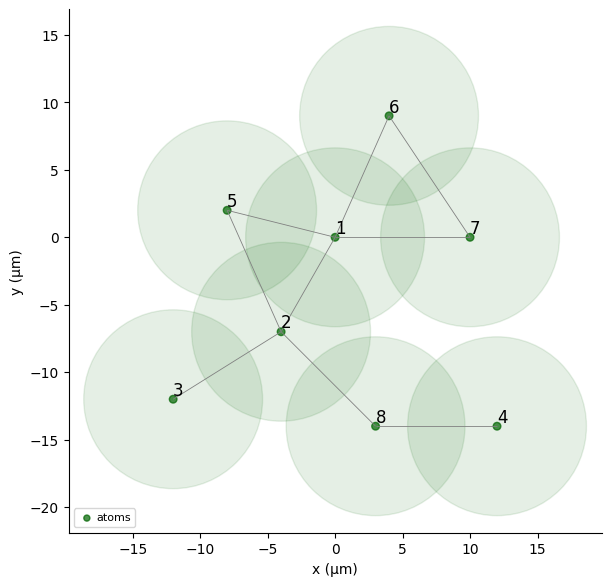

In [16]:
qubits = {'1': (0,0), '2': (-4,-7), '3': (-12, -12), '4': (12,-14), '5': (-8, 2),  '6': (4,9), '7': (10,0), '8': (3,-14)}
reg2 = Register(qubits) 
reg2.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

## 2.2 Variational process 

In [22]:
# Building the quantum loop

def quantum_loop_8(parameters):
    
    params = np.array(parameters)

    parameter_time, parameter_omega, parameter_detuning = np.reshape(params.astype(int), 3)
    
    seq = adiabatic_sequence(Chadoq2,reg2, parameter_time, Omega = parameter_omega, detuning = parameter_detuning)

    simul = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
    res = simul.run()
    counts = res.sample_final_state(N_samples = 1000) #Sample from the state vector
    #print(counts)
    
    return counts


In [23]:
## Cost function to minimize
def func_8(param, *args):
    G_8 = args[0]
    C = quantum_loop_8(param)
    cost = get_avg_cost(C, G_8)
    
    return cost

In [63]:
scores = []
params = []

for repetition in range(15):
    
    random_omega = np.random.uniform(1,5)
    random_detuning = np.random.uniform(2,5)
    random_time = 1000*np.random.randint(21,35)
    
    res_8 = minimize(
        func_8,
        args = G_8,
        x0 = np.r_[random_time, random_omega,random_detuning],
        method = 'Nelder-Mead',
        tol = 1e-5,
        options = {'maxiter':10},
    )
    print(res_8.fun)
    scores.append(res_8.fun)
    params.append(res_8.x)

/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 31685 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 31688 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 30441 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 30444 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 30994 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 30996 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 30277 ns is not a multiple of the channel's clock period (4 ns

5.31


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 21266 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 21268 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 20777 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 20780 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 21694 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 21696 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 21083 ns is not a multiple of the channel's clock period (4 ns

7.123


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 33046 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 33048 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 33207 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 33208 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 33251 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 33252 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 33385 ns is not a multiple of the channel's clock period (4 ns

7.102


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 26550 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 26552 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 26125 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 26128 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 25687 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 25688 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 26375 ns is not a multiple of the channel's clock period (4 ns

5.181


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 26287 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 26288 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 27562 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 27564 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 26606 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 26608 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 26887 ns is not a multiple of the channel's clock period (4 ns

7.024


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 20475 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 20476 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 21466 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 21468 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 20722 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 20724 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 20902 ns is not a multiple of the channel's clock period (4 ns

4.483


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24687 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 24688 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 25590 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 25592 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24913 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 24916 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24843 ns is not a multiple of the channel's clock period (4 ns

4.96


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24533 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 24536 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24639 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 24640 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24373 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 24376 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24389 ns is not a multiple of the channel's clock period (4 ns

4.833


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 27066 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 27068 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 27549 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 27552 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 28342 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 28344 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 27993 ns is not a multiple of the channel's clock period (4 ns

5.878


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 36266 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 36268 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 39666 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 39668 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 39729 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 39732 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 37379 ns is not a multiple of the channel's clock period (4 ns

5.354


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 22366 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 22368 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 21725 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 21728 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 22343 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 22344 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 22206 ns is not a multiple of the channel's clock period (4 ns

7.269


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 25166 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 25168 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24777 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 24780 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24894 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 24896 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 24362 ns is not a multiple of the channel's clock period (4 ns

5.266


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 28033 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 28036 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 26583 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 26584 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 27925 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 27928 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 28006 ns is not a multiple of the channel's clock period (4 ns

5.377


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 33055 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 33056 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 35038 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 35040 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 35550 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 35552 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 35275 ns is not a multiple of the channel's clock period (4 ns

7.023


/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 19541 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 19544 ns.
  self._add(pulse, channel, protocol)
/home/onofre/anaconda3/envs/pasqal_molecular/lib/python3.8/site-packages/pulser/sequence/sequence.py:1283: UserWarning: A duration of 19775 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 19776 ns.
  self._add(pulse, channel, protocol)


5.29


In [64]:
scores

[5.31,
 7.123,
 7.102,
 5.181,
 7.024,
 4.483,
 4.96,
 4.833,
 5.878,
 5.354,
 7.269,
 5.266,
 5.377,
 7.023,
 5.29]

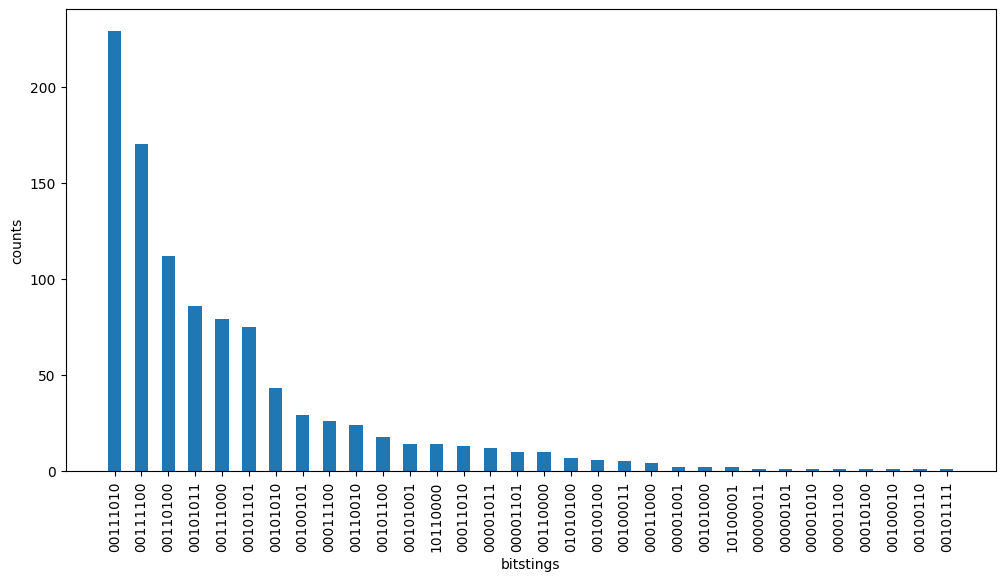

In [65]:
optimial_count_dict = quantum_loop_8(params[np.argmin(scores)])
plot_distribution(optimial_count_dict)

In [67]:
optimial_count_dict

Counter({'00000011': 1,
         '00000101': 1,
         '00001001': 2,
         '00001010': 1,
         '00001011': 12,
         '00001100': 1,
         '00001101': 10,
         '00010100': 1,
         '00011000': 4,
         '00011010': 13,
         '00011100': 26,
         '00100010': 1,
         '00100011': 5,
         '00100100': 6,
         '00100101': 29,
         '00100110': 1,
         '00101000': 2,
         '00101001': 14,
         '00101010': 43,
         '00101011': 86,
         '00101100': 18,
         '00101101': 75,
         '00101111': 1,
         '00110000': 10,
         '00110010': 24,
         '00110100': 112,
         '00111000': 79,
         '00111010': 229,
         '00111100': 170,
         '01010100': 7,
         '10100001': 2,
         '10110000': 14})

In [66]:
params[np.argmin(scores)]

array([2.07803273e+04, 3.96411820e+00, 2.40445477e+00])

/tmp/ipykernel_24656/3115109674.py:18: UserWarning: A waveform duration of 20780.327289094646 ns is below the supported precision of 1 ns. It was rounded down to 20780 ns.
  InterpolatedWaveform(time, [1e-9, Omega, 1e-9]),
/tmp/ipykernel_24656/3115109674.py:19: UserWarning: A waveform duration of 20780.327289094646 ns is below the supported precision of 1 ns. It was rounded down to 20780 ns.
  InterpolatedWaveform(time, [delta_0, 0, delta_f]),


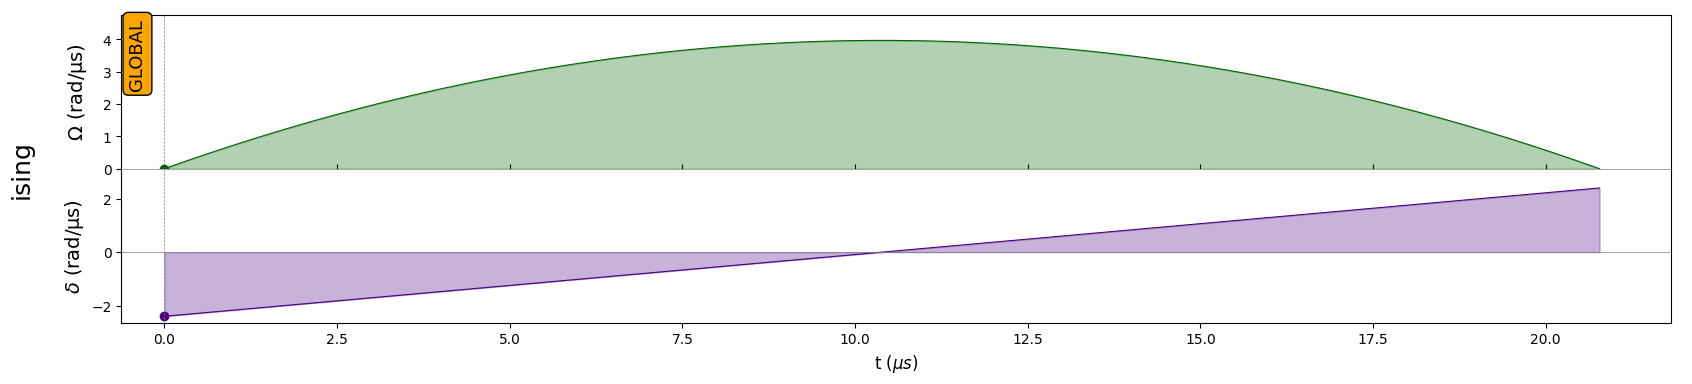

In [68]:
seq = adiabatic_sequence(Chadoq2,reg, params[np.argmin(scores)][0], params[np.argmin(scores)][1], params[np.argmin(scores)][2])

seq.draw()